# Visualizing Activation Map on a pretrained Model 

 # Importing librarires

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from keras.models import load_model
from keras.metrics import mean_absolute_error

# Loading Pretrained Model

In [ ]:
model_path = "C:\\Users\\anshu yadav\\Desktop\\project Age gender Detector\\Age_Sex_Detection.h5"
model = load_model(model_path, custom_objects={'mae': mean_absolute_error})



# Preprocessing image

In [3]:

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (48, 48))
    img = img / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img, axis=0)
    return img_array, img


# Function to extract activations

In [4]:

def get_activation_maps(model, img_array, layer_names):
    activation_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(layer).output for layer in layer_names]
    )
    return activation_model.predict(img_array)

def generate_heatmap(activation_map, original_img):
    if np.max(activation_map) > np.min(activation_map):
        activation_map = (activation_map - np.min(activation_map)) / (np.max(activation_map) - np.min(activation_map))
    else:
        activation_map = np.full_like(activation_map, 0.1)  # Small value to avoid blank heatmap

    heatmap = cv2.resize(activation_map, (original_img.shape[1], original_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Ensure original image is in uint8 format
    
    original_img = (original_img * 255).astype(np.uint8)  

    superimposed = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)
    return heatmap, np.clip(superimposed, 0, 255).astype(np.uint8)

# Function to visualize activations

In [5]:

def visualize_activations(img_path, model, layer_names):
    img_array, original_img = preprocess_image(img_path)
    activations = get_activation_maps(model, img_array, layer_names)

    plt.figure(figsize=(20, 10))
    plt.suptitle("Activation Maps")

    for i, (layer_name, activation) in enumerate(zip(layer_names, activations)):
        activation = activation[0]
        num_filters = min(8, activation.shape[-1])

        for j in range(num_filters):
            activation_map = activation[:, :, j]

            # Avoid division by zero & improve visibility
            if np.max(activation_map) == np.min(activation_map):
                activation_map += 0.1 * np.random.rand(*activation_map.shape)  

            activation_map = (activation_map - np.min(activation_map)) / (np.max(activation_map) - np.min(activation_map) + 1e-10)

            plt.subplot(len(layer_names), num_filters, i * num_filters + j + 1)
            plt.imshow(activation_map, cmap='viridis')
            plt.axis('off')
            plt.title(f"{layer_name} - F{j}")

    plt.tight_layout()
    plt.show()


# creating a heatmap grid for a specific layer

In [6]:

def create_heatmap_grid(img_path, model, layer_name, num_filters=8):
    img_array, original_img = preprocess_image(img_path)

    activation_model = tf.keras.models.Model(
        inputs=model.input, outputs=model.get_layer(layer_name).output
    )
    activation = activation_model.predict(img_array)[0]

    num_filters = min(num_filters, activation.shape[-1])
    filter_indices = np.argsort([np.mean(activation[:, :, i]) for i in range(activation.shape[-1])])[-num_filters:]

    plt.figure(figsize=(15, 10))
    plt.suptitle(f"Heatmap Grid for Layer: {layer_name}")

    for i, filter_idx in enumerate(filter_indices):
        heatmap, superimposed = generate_heatmap(activation[:, :, filter_idx], original_img)

        plt.subplot(2, num_filters, i + 1)
        plt.imshow(superimposed)
        plt.title(f"Filter {filter_idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Testing Model

# Defining layer names

In [7]:
layer_names = ['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3']

#  visualizatizing Activation Maps and Heatmap

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


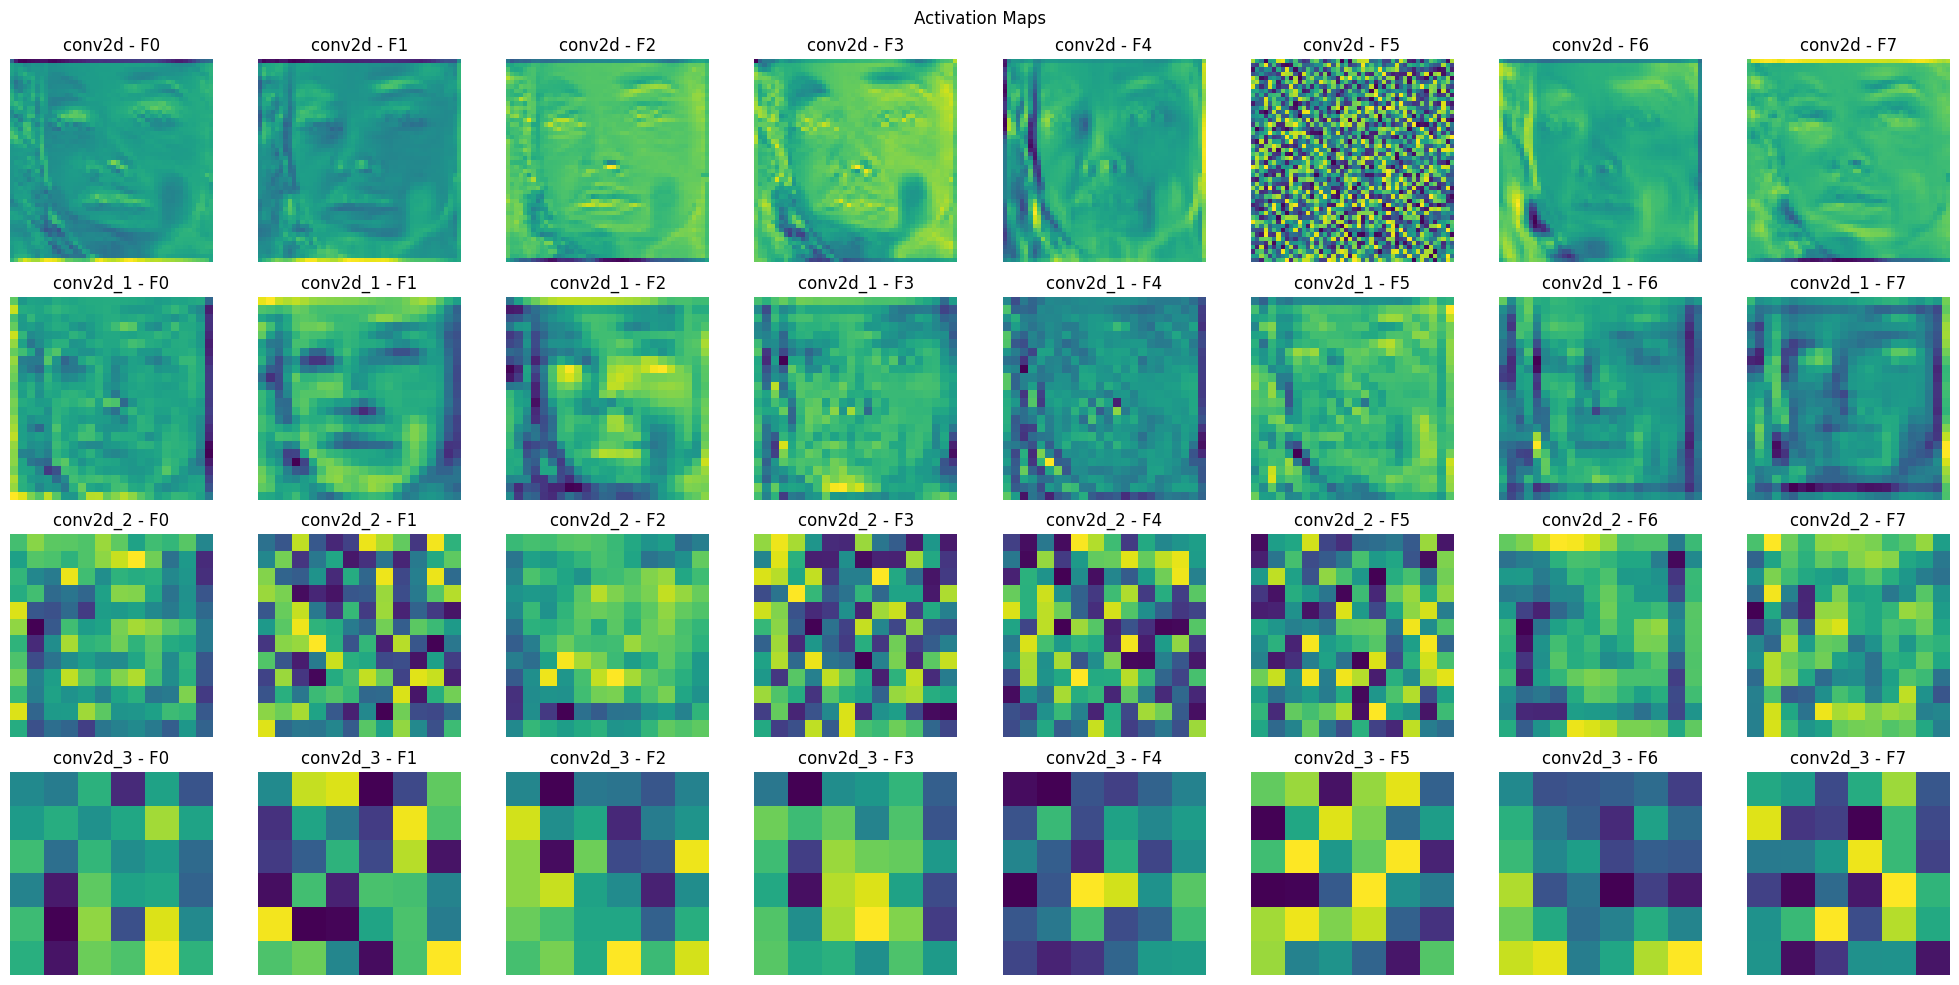

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


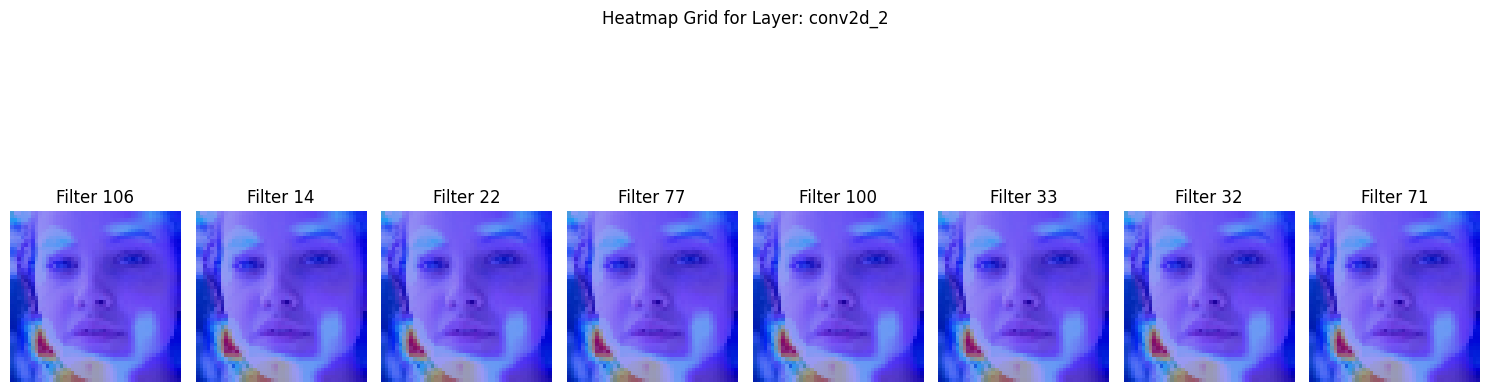

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step


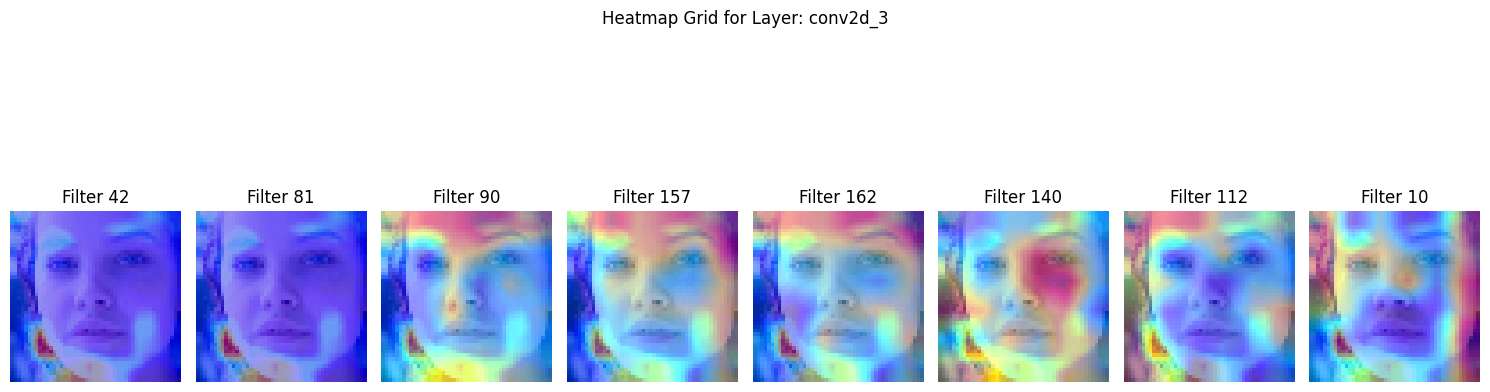

In [8]:
img_path = "C:\\Users\\anshu yadav\\Desktop\\project Age gender Detector\\UTKFace\\16_1_0_20170109213604149.jpg.chip.jpg"
visualize_activations(img_path, model, layer_names)
create_heatmap_grid(img_path, model, "conv2d_2", num_filters=8)
create_heatmap_grid(img_path, model, "conv2d_3", num_filters=8)